In [23]:
import numpy as np
import matplotlib.pyplot as plt
import matplotlib
from matplotlib import cm
import seaborn as sns
import time

import astropy
import astropy.units as u
from astropy.coordinates import SkyCoord, match_coordinates_sky
from astropy.table import Table, join

from dustmaps.sfd import SFDQuery

import healpy as hp
import pandas as pd
from sklearn.neighbors import KDTree

import sys
sys.path.insert(0,'../code')
%load_ext autoreload
%autoreload 2
import utils
import specphotoz
from specphotoz import RedshiftEstimatorkNN, RedshiftEstimatorANN

The autoreload extension is already loaded. To reload it, use:
  %reload_ext autoreload


In [2]:
# -------------------------------------------------------------------------------
# plotting settings
# -------------------------------------------------------------------------------

colors = ["windows blue", "amber", "greyish", "faded green", "dusty purple", "pale red"]
colors = sns.xkcd_palette(colors)
#colors = sns.color_palette("Blues")

matplotlib.rcParams['ytick.labelsize'] = 18
matplotlib.rcParams['xtick.labelsize'] = 18
matplotlib.rcParams['axes.labelsize'] = 22
matplotlib.rcParams['legend.fontsize'] = 18

matplotlib.rc('text', usetex=True)
fsize = 18

colors_cont = ["black", "grey", "light grey"] 
colors_cont = sns.xkcd_palette(colors_cont)

np.random.seed(40)

In [3]:
redshift_estimator_dict = {'kNN': RedshiftEstimatorkNN,
                           'ANN': RedshiftEstimatorANN
                           }

## Read in data

In [21]:
# Load data
print("Loading data")
fn_gaia = '../data/gaia_clean.fits'
tab_gaia = utils.load_table(fn_gaia)
# TEST ONLY W SMALL AMOUNT
#tab_gaia = tab_gaia[np.random.randint(0, len(tab_gaia), size=10000)]
N_gaia = len(tab_gaia)
print(f"N of clean gaia catalog: {N_gaia}")

Loading data
N of clean gaia catalog: 1451214


In [22]:
# Make Gmax cut, because will be more robust that way if we cut first
i_makeGcut = tab_gaia['phot_g_mean_mag'] < G_max
tab_gaia = tab_gaia[i_makeGcut]
print(f"N after G_max cut of G<{G_max}:", len(tab_gaia))

N after G_max cut of G<20.5: 1104830


In [24]:
feature_keys = ['redshift_qsoc', 'ebv', 'g_rp', 'bp_g', 'bp_rp', 'g_w1', 'w1_w2', 'phot_g_mean_mag']
X_gaia = specphotoz.construct_X(tab_gaia, feature_keys)

# ANN

In [4]:
redshift_estimator_name = 'ANN'
G_max = 20.5
learning_rate = 0.005
save_tag = f'_lr{learning_rate}_valid'
#save_tag = '_lr0.005'

In [5]:
fn_spz = f'../data/redshift_estimates/redshifts_spz_{redshift_estimator_name}_G{G_max}{save_tag}.fits'
tab_spz = Table.read(fn_spz, format='fits')

In [6]:
fn_model = f'../data/redshift_models/model_spz_{redshift_estimator_name}_G{G_max}{save_tag}.fits'
redshift_estimator_class = redshift_estimator_dict[redshift_estimator_name]                        
redshift_estimator = redshift_estimator_class(train_mode=False, test_mode=False)
redshift_estimator.load_model(fn_model)

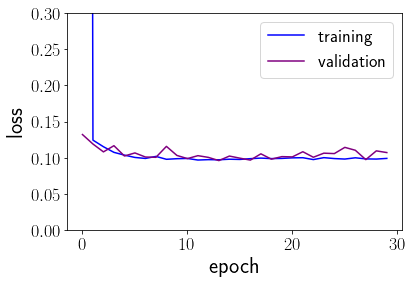

In [7]:
plt.plot(redshift_estimator.loss_train, color='blue', label='training')
plt.plot(redshift_estimator.loss_valid, color='purple', label='validation')
plt.ylim(0, 0.3)
plt.xlabel('epoch')
plt.ylabel('loss')
plt.legend()

In [8]:
i_test = tab_spz['chunk_spz']=='test'

In [9]:
Y_test = tab_spz['sdss_Z'][i_test]
Y_spz_test = tab_spz['redshift_spz'][i_test]
Y_qsoc_test = tab_spz['redshift_qsoc'][i_test]

In [10]:
dzs = [0.01, 0.1, 0.2, 1.0]
for dz in dzs:
    print(f"Fraction recovered with Dz/(1+z)<{dz}:")
    frac_recovered = utils.get_fraction_recovered(Y_test, Y_spz_test, dz)
    print(f"SPZ: {frac_recovered:.3f}")
    frac_recovered_qsoc = utils.get_fraction_recovered(Y_test, Y_qsoc_test, dz)
    print(f"QSOC: {frac_recovered_qsoc:.3f}")

Fraction recovered with Dz/(1+z)<0.01:
SPZ: 0.105
QSOC: 0.627
Fraction recovered with Dz/(1+z)<0.1:
SPZ: 0.746
QSOC: 0.704
Fraction recovered with Dz/(1+z)<0.2:
SPZ: 0.898
QSOC: 0.727
Fraction recovered with Dz/(1+z)<1.0:
SPZ: 0.999
QSOC: 0.933


Text(0, 0.5, '$z_{SPZ}$, spectro-photometric redshift')

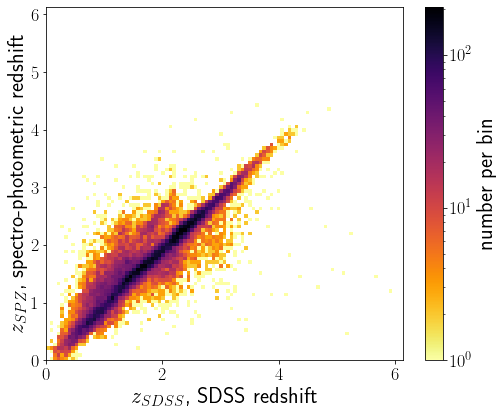

In [12]:
z_bins = np.linspace(0, np.max(tab_spz['redshift_qsoc']), 100)
fig, ax = plt.subplots(1, 1, figsize = (8, 6.5))
h = ax.hist2d(tab_spz['sdss_Z'][i_test], tab_spz['redshift_spz'][i_test], 
              bins=z_bins, cmin=1, cmap='inferno_r',
             norm=matplotlib.colors.LogNorm())
fig.colorbar(h[3], ax=ax, label='number per bin')

plt.xlabel(r'$z_{SDSS}$, SDSS redshift')
plt.ylabel(r'$z_{SPZ}$, spectro-photometric redshift')

Text(0, 0.5, '$z_{QSOC}$, QSOC redshift')

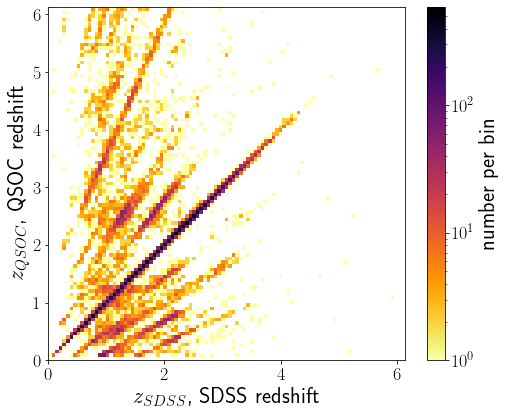

In [13]:
z_bins = np.linspace(0, np.max(tab_spz['redshift_qsoc']), 100)
fig, ax = plt.subplots(1, 1, figsize = (8, 6.5))
h = ax.hist2d(Y_test, Y_qsoc_test, 
              bins=z_bins, cmin=1, cmap='inferno_r',
             norm=matplotlib.colors.LogNorm())
fig.colorbar(h[3], ax=ax, label='number per bin')

plt.xlabel(r'$z_{SDSS}$, SDSS redshift')
plt.ylabel(r'$z_{QSOC}$, QSOC redshift')

Text(0, 0.5, 'number per bin')

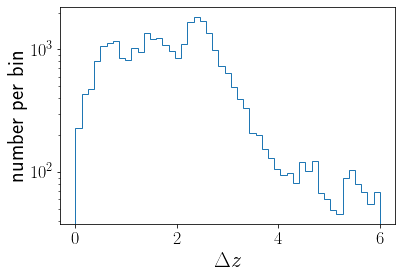

In [14]:
#plt.title(rf'$G<{G_max_spz}$', fontsize=24)
plt.hist(Y_qsoc_test, bins=np.linspace(0,6,50), histtype='step')
plt.yscale('log')
plt.xlabel(r'$\Delta z$')
plt.ylabel('number per bin')

Text(0, 0.5, 'number per bin')

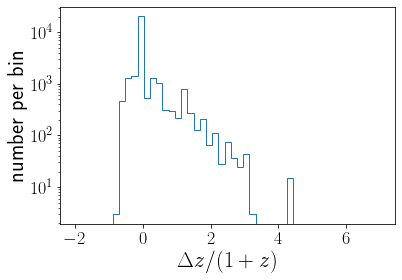

In [15]:
#plt.title(rf'$G<{G_max_spz}$', fontsize=24)
plt.hist((Y_qsoc_test - Y_test)/(1+Y_test), bins=np.linspace(-2,7,50), histtype='step')
plt.yscale('log')
plt.xlabel(r'$\Delta z/(1+z)$')
plt.ylabel('number per bin')

(-0.2, 0.2)

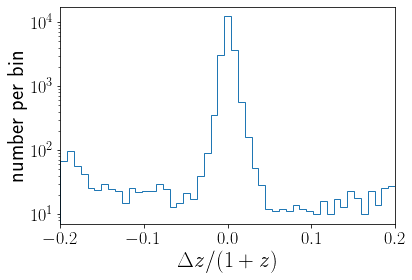

In [17]:
#plt.title(rf'$G<{G_max_spz}$', fontsize=24)
plt.hist((Y_qsoc_test - Y_test)/(1+Y_test), bins=np.linspace(-0.2,0.2,50), histtype='step')
plt.yscale('log')
plt.xlabel(r'$\Delta z/(1+z)$')
plt.ylabel('number per bin')
plt.xlim(-0.2, 0.2)

## kNN

In [4]:
redshift_estimator_name = 'kNN'
G_max = 20.5
save_tag = '_valid'

In [5]:
fn_spz = f'../data/redshift_estimates/redshifts_spz_{redshift_estimator_name}_G{G_max}{save_tag}.fits'
tab_spz = Table.read(fn_spz, format='fits')

In [6]:
i_test = tab_spz['chunk_spz']=='test'

In [7]:
Y_test = tab_spz['sdss_Z'][i_test]
Y_spz_test = tab_spz['redshift_spz'][i_test]
Y_qsoc_test = tab_spz['redshift_qsoc'][i_test]

In [8]:
dzs = [0.01, 0.1, 0.2, 1.0]
for dz in dzs:
    print(f"Fraction recovered with Dz/(1+z)<{dz}:")
    frac_recovered = utils.get_fraction_recovered(Y_test, Y_spz_test, dz)
    print(f"SPZ: {frac_recovered:.3f}")
    frac_recovered_qsoc = utils.get_fraction_recovered(Y_test, Y_qsoc_test, dz)
    print(f"QSOC: {frac_recovered_qsoc:.3f}")

Fraction recovered with Dz/(1+z)<0.01:
SPZ: 0.379
QSOC: 0.627
Fraction recovered with Dz/(1+z)<0.1:
SPZ: 0.826
QSOC: 0.704
Fraction recovered with Dz/(1+z)<0.2:
SPZ: 0.902
QSOC: 0.727
Fraction recovered with Dz/(1+z)<1.0:
SPZ: 0.999
QSOC: 0.933


Text(0, 0.5, '$z_{SPZ}$, spectro-photometric redshift')

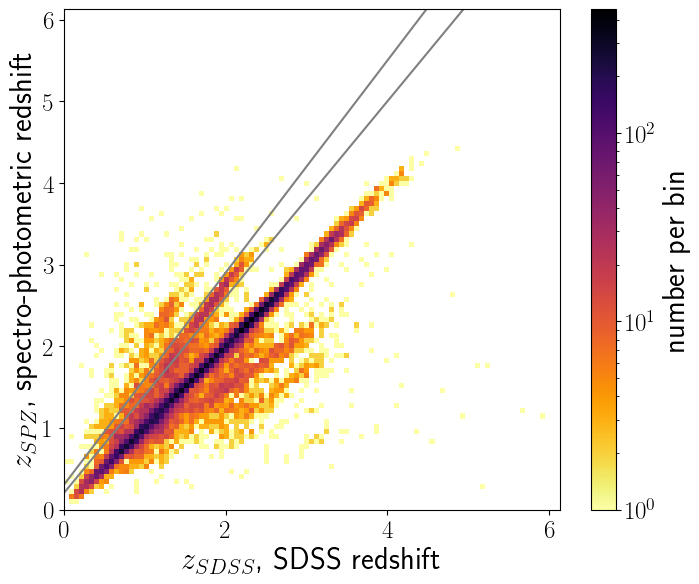

In [18]:
z_bins = np.linspace(0, np.max(tab_spz['redshift_qsoc']), 100)
fig, ax = plt.subplots(1, 1, figsize = (8, 6.5))
h = ax.hist2d(tab_spz['sdss_Z'][i_test], tab_spz['redshift_spz'][i_test], 
              bins=z_bins, cmin=1, cmap='inferno_r',
             norm=matplotlib.colors.LogNorm())
fig.colorbar(h[3], ax=ax, label='number per bin')

dz_min, dz_max = 0.2, 0.3
xx = np.linspace(0, np.max(tab_spz['redshift_qsoc']))
yy_min = dz_min*(1+xx) + xx
yy_max = dz_max*(1+xx) + xx
plt.plot(xx, yy_min, color='grey')
plt.plot(xx, yy_max, color='grey')

plt.xlabel(r'$z_{SDSS}$, SDSS redshift')
plt.ylabel(r'$z_{SPZ}$, spectro-photometric redshift')

In [10]:
z_test_sdss = tab_spz['sdss_Z'][i_test]
z_test_spz = tab_spz['redshift_spz'][i_test]

In [11]:
dz_noabs = (z_test_spz - z_test_sdss)/(1 + z_test_sdss)

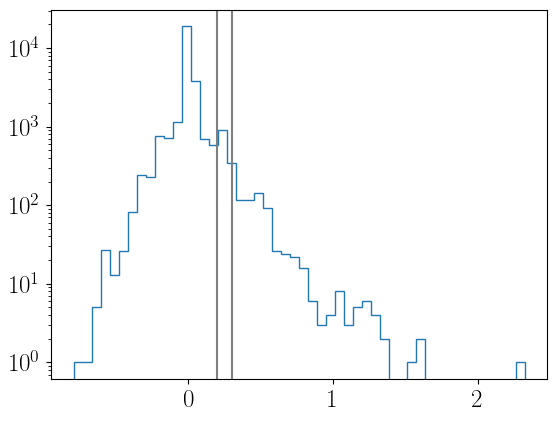

In [16]:
plt.hist(dz_noabs, histtype='step', bins=50)
plt.yscale('log')

plt.axvline(dz_min,color='grey')
plt.axvline(dz_max,color='grey')

In [20]:
i_inline = (dz_noabs>dz_min) & (dz_noabs<dz_max)
print(np.sum(i_inline))
print(np.sum(i_inline)/len(i_inline))

1216
0.04175537394409724


In [ ]:
plt.scatter()

## ANN Dz/(1+z) loss

In [175]:
redshift_estimator_name = 'ANN'
G_max = 20.5
save_tag = '_valid_lossdz'

In [176]:
fn_spz = f'../data/redshift_estimates/redshifts_spz_{redshift_estimator_name}_G{G_max}{save_tag}.fits'
tab_spz = Table.read(fn_spz, format='fits')

In [177]:
i_test = tab_spz['chunk_spz']=='test'

In [178]:
Y_test = tab_spz['sdss_Z'][i_test]
Y_spz_test = tab_spz['redshift_spz'][i_test]
Y_qsoc_test = tab_spz['redshift_qsoc'][i_test]

In [179]:
dzs = [0.01, 0.1, 0.2, 1.0]
for dz in dzs:
    print(f"Fraction recovered with Dz/(1+z)<{dz}:")
    frac_recovered = utils.get_fraction_recovered(Y_test, Y_spz_test, dz)
    print(f"SPZ: {frac_recovered:.3f}")
    frac_recovered_qsoc = utils.get_fraction_recovered(Y_test, Y_qsoc_test, dz)
    print(f"QSOC: {frac_recovered_qsoc:.3f}")

Fraction recovered with Dz/(1+z)<0.01:
SPZ: 0.055
QSOC: 0.627
Fraction recovered with Dz/(1+z)<0.1:
SPZ: 0.528
QSOC: 0.704
Fraction recovered with Dz/(1+z)<0.2:
SPZ: 0.787
QSOC: 0.727
Fraction recovered with Dz/(1+z)<1.0:
SPZ: 0.999
QSOC: 0.933


Text(0, 0.5, '$z_{SPZ}$, spectro-photometric redshift')

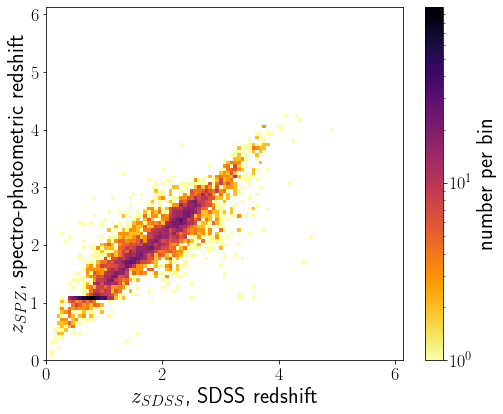

In [180]:
z_bins = np.linspace(0, np.max(tab_spz['redshift_qsoc']), 100)
fig, ax = plt.subplots(1, 1, figsize = (8, 6.5))
h = ax.hist2d(tab_spz['sdss_Z'][i_test], tab_spz['redshift_spz'][i_test], 
              bins=z_bins, cmin=1, cmap='inferno_r',
             norm=matplotlib.colors.LogNorm())
fig.colorbar(h[3], ax=ax, label='number per bin')

plt.xlabel(r'$z_{SDSS}$, SDSS redshift')
plt.ylabel(r'$z_{SPZ}$, spectro-photometric redshift')

# All data

In [89]:
#tab_gaia = Table.read('../data/gaia_wise_panstarrs_tmass.fits.gz', format='fits')
tab_gaia = Table.read('../data/gaia_slim_xsdss.fits', format='fits')
print('Total number of Gaia quasars:', len(tab_gaia))

Total number of Gaia quasars: 6649162


In [90]:
tab_spz_slim = tab_spz.copy()
tab_spz_slim.keep_columns(['source_id', 'redshift_spz'])
tab_gaia = astropy.table.join(tab_gaia, tab_spz_slim, keys='source_id', join_type='left')

In [91]:
tab_gaia.columns

<TableColumns names=('ra','dec','redshift_qsoc','l','b','source_id','parallax','parallax_error','pmra','pmra_error','pmdec','pmdec_error','phot_g_mean_mag','phot_bp_mean_mag','phot_rp_mean_mag','redshift_qsoc_lower','redshift_qsoc_upper','zscore_qsoc','flags_qsoc','allwise_oid','w1mpro','w2mpro','rand_ints','g_rp','bp_g','bp_rp','g_w1','w1_w2','ebv','A_v','pm','sdss_SDSS_NAME','sdss_OBJID','sdss_THING_ID','sdss_RA','sdss_DEC','sdss_Z','redshift_spz')>

In [92]:
idx_withspz = np.isfinite(tab_gaia['redshift_spz'])
np.sum(idx_withspz)

1104830

In [93]:
idx_withsdss = np.isfinite(tab_gaia['sdss_Z'])
np.sum(idx_withsdss)

327096

In [94]:
fn_sdss = '../data/sdss_slim.fits'
tab_sdss = Table.read(fn_sdss, format='fits')

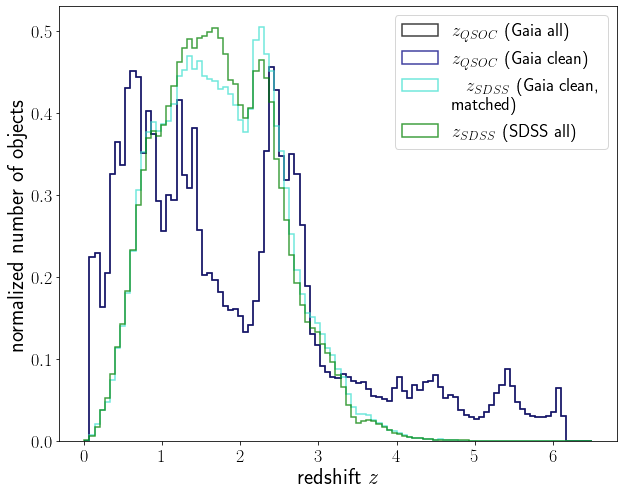

In [97]:
alpha = 0.75
lw = 1.5
density = True
histtype='step'
z_bins = np.linspace(0,6.5,100)

plt.figure(figsize=(10,8))
_ = plt.hist(tab_gaia['redshift_qsoc'], bins=z_bins, alpha=alpha, color='k', lw=lw,
             density=density, histtype=histtype, label=r'$z_{QSOC}$ (Gaia all)')
_ = plt.hist(tab_gaia['redshift_qsoc'][idx_withspz], bins=z_bins, alpha=alpha, color='navy', lw=lw,
             density=density, histtype=histtype, label=r'$z_{QSOC}$ (Gaia clean)')
# _ = plt.hist(tab_gaia['redshift_spz'], bins=z_bins, alpha=alpha, color='m', lw=lw, 
#              density=density, histtype=histtype, label=r'$z_{SPZ}$ (Gaia clean)')
_ = plt.hist(tab_gaia['sdss_Z'], bins=z_bins, alpha=alpha, color='turquoise', lw=lw,
             density=density, histtype=histtype, label=r'$z_{SDSS}$ (Gaia clean,\\matched)')
_ = plt.hist(tab_sdss['Z'], bins=z_bins, alpha=alpha, color='g', lw=lw,
             density=density, histtype=histtype, label=r'$z_{SDSS}$ (SDSS all)')
plt.xlabel(r'redshift $z$')
plt.ylabel('normalized number of objects')
plt.legend()

Text(0, 0.5, '$z_{QSOC}$, Gaia QSOC redshift')

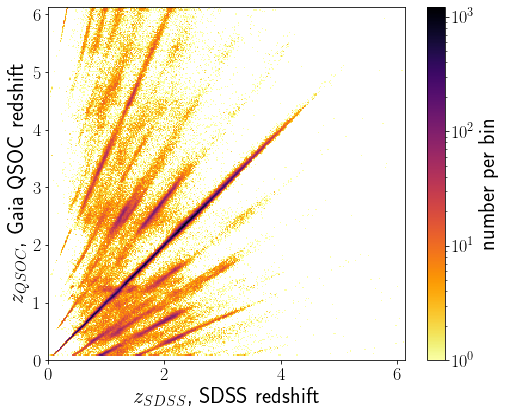

In [99]:
z_bins = np.linspace(0, np.max(tab_gaia['redshift_qsoc']), 300)
fig, ax = plt.subplots(1, 1, figsize = (8, 6.5))
h = ax.hist2d(tab_gaia['sdss_Z'], tab_gaia['redshift_qsoc'], bins=z_bins, cmin=1, cmap='inferno_r',
             norm=matplotlib.colors.LogNorm())
fig.colorbar(h[3], ax=ax, label='number per bin')

plt.xlabel(r'$z_{SDSS}$, SDSS redshift')
plt.ylabel(r'$z_{QSOC}$, Gaia QSOC redshift')

In [100]:
def get_fraction_recovered(Y_true, Y_hat, z_err_close):
    return np.sum(np.abs(Y_true - Y_hat) < z_err_close) / len(Y_true)

def mse(Y_true, Y_hat):
    return np.mean((Y_true - Y_hat)**2, axis=0)

Text(0, 0.5, '$z_{SPZ}$, spectro-photometric redshift')

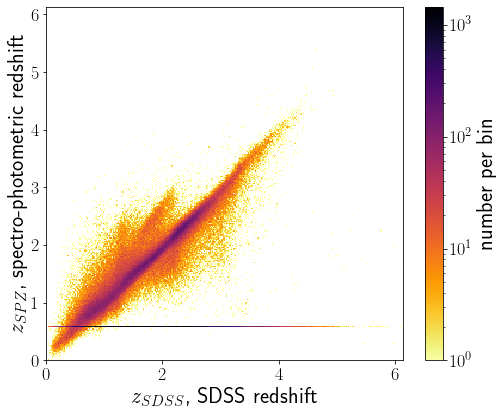

In [102]:
z_bins = np.linspace(0, np.max(tab_gaia['redshift_qsoc']), 300)
fig, ax = plt.subplots(1, 1, figsize = (8, 6.5))
h = ax.hist2d(tab_gaia['sdss_Z'], tab_gaia['redshift_spz'], bins=z_bins, cmin=1, cmap='inferno_r',
             norm=matplotlib.colors.LogNorm())
fig.colorbar(h[3], ax=ax, label='number per bin')

plt.xlabel(r'$z_{SDSS}$, SDSS redshift')
plt.ylabel(r'$z_{SPZ}$, spectro-photometric redshift')

In [104]:
mse_spz = mse(tab_gaia['sdss_Z'][idx_withsdss], tab_gaia['redshift_spz'][idx_withsdss])
mse_baseline = mse(tab_gaia['sdss_Z'][idx_withsdss], tab_gaia['redshift_qsoc'][idx_withsdss])
print(f"MSE: {mse_spz:.3f} (Baseline: {mse_baseline:.3f})")

MSE: 0.096 (Baseline: 1.347)


In [107]:
z_errs_close = [0.1, 0.2]
print("Number of test objects: ", len(tab_gaia['sdss_Z'][idx_withsdss]))
for z_err_close in z_errs_close:
    frac_recovered = get_fraction_recovered(tab_gaia['sdss_Z'][idx_withsdss], 
                                            tab_gaia['redshift_spz'][idx_withsdss], z_err_close)
    frac_recovered_baseline = get_fraction_recovered(tab_gaia['sdss_Z'][idx_withsdss], 
                                            tab_gaia['redshift_qsoc'][idx_withsdss], z_err_close)
    print(rf"Fraction recovered with Dz<{z_err_close}: {frac_recovered:.3f}")
    print(rf"(Baseline: {frac_recovered_baseline:.3f})")

Number of test objects:  327096
Fraction recovered with Dz<0.1: 0.288
(Baseline: 0.592)
Fraction recovered with Dz<0.2: 0.421
(Baseline: 0.602)


In [108]:
z_errs_close = [0.1, 0.2]
print("Number of test objects: ", len(tab_gaia['sdss_Z'][idx_withsdss]))
for z_err_close in z_errs_close:
    frac_recovered = utils.get_fraction_recovered(tab_gaia['sdss_Z'][idx_withsdss], 
                                            tab_gaia['redshift_spz'][idx_withsdss], z_err_close)
    frac_recovered_baseline = utils.get_fraction_recovered(tab_gaia['sdss_Z'][idx_withsdss], 
                                            tab_gaia['redshift_qsoc'][idx_withsdss], z_err_close)
    print(rf"Fraction recovered with dz<{z_err_close}: {frac_recovered:.3f}")
    print(rf"(Baseline: {frac_recovered_baseline:.3f})")

Number of test objects:  327096
Fraction recovered with dz<0.1: 0.452
(Baseline: 0.604)
Fraction recovered with dz<0.2: 0.538
(Baseline: 0.637)


# G<20 only

In [21]:
G_max = 20
idx_G = tab_gaia['phot_g_mean_mag'][idx_withsdss] < G_max
z_errs_close = [0.1, 0.2]
print("Number of test objects: ", len(tab_gaia['redshift_sdss'][idx_withsdss][idx_G]))
for z_err_close in z_errs_close:
    frac_recovered = get_fraction_recovered(tab_gaia['redshift_sdss'][idx_withsdss][idx_G], 
                                            tab_gaia['redshift_spz'][idx_withsdss][idx_G], z_err_close)
    frac_recovered_baseline = get_fraction_recovered(tab_gaia['redshift_sdss'][idx_withsdss][idx_G], 
                                            tab_gaia['redshift_qsoc'][idx_withsdss][idx_G], z_err_close)
    print(rf"Fraction recovered with $\delta z$<{z_err_close}: {frac_recovered:.3f}")
    print(rf"(Baseline: {frac_recovered_baseline:.3f})")

Number of test objects:  168065
Fraction recovered with $\delta z$<0.1: 0.742
(Baseline: 0.818)
Fraction recovered with $\delta z$<0.2: 0.862
(Baseline: 0.823)


## Cumulative dist

In [22]:
delta_z = tab_gaia['redshift_sdss'][idx_withsdss] - tab_gaia['redshift_spz'][idx_withsdss]
delta_z_G = tab_gaia['redshift_sdss'][idx_withsdss][idx_G] - tab_gaia['redshift_spz'][idx_withsdss][idx_G]

Text(0, 0.5, 'number per bin')

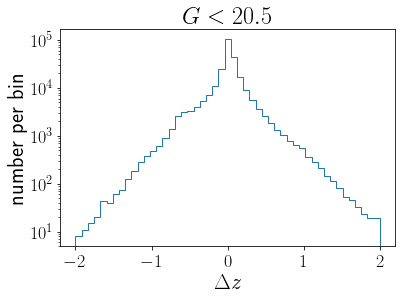

In [23]:
plt.title(rf'$G<{G_max_spz}$', fontsize=24)
plt.hist(delta_z, bins=np.linspace(-2,2,50), histtype='step')
plt.yscale('log')
plt.xlabel(r'$\Delta z$')
plt.ylabel('number per bin')

(0.0, 1.0)

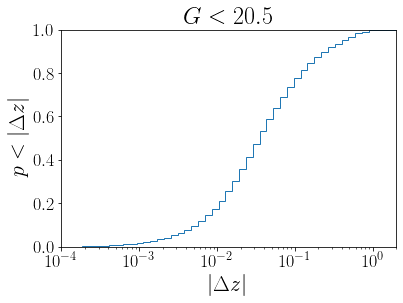

In [24]:
plt.title(rf'$G<{G_max_spz}$', fontsize=24)
plt.hist(abs(delta_z_G), bins=np.logspace(-4, np.log10(2), 50), histtype='step', cumulative=True, density=True)
plt.xlabel(r'$|\Delta z|$')
plt.ylabel(r'$p < |\Delta z|$')
plt.xscale('log')
plt.xlim(1e-4, 2)
plt.ylim(0,1)

Text(0, 0.5, 'number per bin')

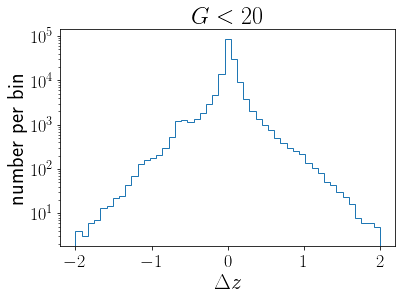

In [25]:
plt.title(rf'$G<{G_max}$', fontsize=24)
plt.hist(delta_z_G, bins=np.linspace(-2,2,50), histtype='step')
plt.yscale('log')
plt.xlabel(r'$\Delta z$')
plt.ylabel('number per bin')

(0.0, 1.0)

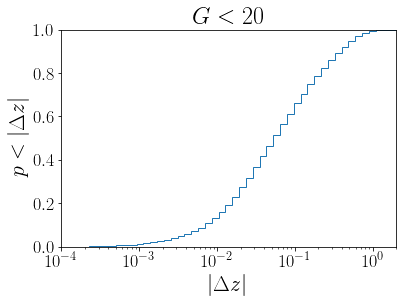

In [26]:
plt.title(rf'$G<{G_max}$', fontsize=24)
plt.hist(abs(delta_z), bins=np.logspace(-4, np.log10(2), 50), histtype='step', cumulative=True, density=True)
plt.xlabel(r'$|\Delta z|$')
plt.ylabel(r'$p < |\Delta z|$')
plt.xscale('log')
plt.xlim(1e-4, 2)
plt.ylim(0,1)